In [1]:
# Importing all needed libraries
## Exloratory Data Analysis and Visualization
import os
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from skbio.stats.composition import clr, multi_replace
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import seaborn as sns

## Create functions required for data cleaning, scaling and visualization

In [3]:
# Set paths for the datasets
DATA_PATH = os.path.join('..', 'data')
dev_set_path = os.path.join(DATA_PATH, "assignment1_dev_set.csv")
val_set_path = os.path.join(DATA_PATH, "assignment1_val_set.csv")

# Define the columns to drop
COLUMNS_TO_DROP = ['Unnamed: 0', 'Project ID', 'Experiment type', 'Disease MESH ID', 'Sex']

In [63]:
class EmptySampleFilter(BaseEstimator, TransformerMixin):
    """Custom transformer to filter samples with all zeros or only one non-zero feature in features."""
    def __init__(self, target_col=None):
        self.target_col = target_col
        self.valid_samples = None
    
    def fit(self, X, y=None):
        # Check which samples have all zeros or only one non-zero feature in features (excluding target if in X)
        if isinstance(X, pd.DataFrame):
            if self.target_col and self.target_col in X.columns:
                features = X.drop(columns=[self.target_col])
            else:
                features = X
            self.valid_samples = (features != 0).sum(axis=1) > 1
        else:  # numpy array
            self.valid_samples = (X != 0).sum(axis=1) > 1
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X[self.valid_samples]
        else:  # numpy array
            return X[self.valid_samples, :]

class CompositionalTransformer(BaseEstimator, TransformerMixin):
    """Custom transformer to handle zero-inflated compositional data."""
    def __init__(self, exclude_col=None):
        self.exclude_col = exclude_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame) and self.exclude_col and self.exclude_col in X.columns:
            excluded_data = X[self.exclude_col]
            X = X.drop(columns=[self.exclude_col])
            X_imputed = (X + 1e-5)
            transformed = clr(X_imputed)
            transformed[self.exclude_col] = excluded_data.values
            return transformed
        else:
            X_imputed = multi_replace(X)
            return clr(X_imputed)

def data_clean(dataset_path: pd.DataFrame, cols_drop: list = COLUMNS_TO_DROP) -> pd.DataFrame:
    """
    Cleans the dataset by dropping user specified columns and checks for missing values.
    Args:
        dataset_path (str): Path to the dataset.
        cols_drop (list): List of columns to drop from the dataset.
    Returns:
        pd.DataFrame: Cleaned dataset.
    """
    raw_data = pd.read_csv(dataset_path)
    raw_data.drop(columns=cols_drop, inplace=True)
    if raw_data.isna().any().any():
        print("\nWarning: NA values detected!")
        print("Rows with NAs:")
        print(raw_data[raw_data.isna().any(axis=1)].head())
    else:
        print("\nNo NA values found.")
    
    return raw_data

def preprocess_and_save_datasets(dev_df, eval_df, target_col='BMI', age_col='Host age', save_path='../data/'):
    """
    Preprocess datasets using EmptySampleFilter and CompositionalTransformer and save them.
    
    Parameters:
    -----------
    dev_df : pd.DataFrame
        Development dataset
    eval_df : pd.DataFrame
        Evaluation dataset
    target_col : str
        Name of target column (default: 'BMI')
    age_col : str
        Name of age column (default: 'Host age')
    save_path : str
        Path to save processed datasets (default: '../data/')
        
    Returns:
    --------
    Processed development and evaluation datasets
    tuple : (development_final_data.csv and evaluation_final_data.csv)
    """

    # Initialize transformers
    sample_filter = EmptySampleFilter(target_col=target_col)
    comp_transformer = CompositionalTransformer(exclude_col=age_col)
    
    # Process development set
    print("Processing development set...")
    dev_filtered = sample_filter.fit_transform(dev_df)
    
    # Separate features for compositional transformation
    dev_target = dev_filtered[target_col]
    dev_age = dev_filtered[age_col]
    dev_features = dev_filtered.drop(columns=[target_col, age_col])
    
    # Apply CLR transformation
    dev_transformed = comp_transformer.fit_transform(dev_features)
    
    # Reconstruct development dataset (BMI and age first)
    processed_dev = pd.DataFrame()
    processed_dev[target_col] = dev_target
    processed_dev[age_col] = dev_age
    transformed_features = pd.DataFrame(dev_transformed, columns=dev_features.columns, index=dev_filtered.index)
    processed_dev = pd.concat([processed_dev, transformed_features], axis=1)
    
    # Process evaluation set
    print("Processing evaluation set...")
    eval_filtered = sample_filter.fit_transform(eval_df)  # Use transform only, not fit_transform
    
    # Separate features for compositional transformation
    eval_target = eval_filtered[target_col]
    eval_age = eval_filtered[age_col]
    eval_features = eval_filtered.drop(columns=[target_col, age_col])
    
    # Apply CLR transformation using fitted transformer
    eval_transformed = comp_transformer.fit_transform(eval_features)
    
    # Reconstruct evaluation dataset (BMI and age first)
    processed_eval = pd.DataFrame()
    processed_eval[target_col] = eval_target
    processed_eval[age_col] = eval_age
    transformed_features = pd.DataFrame(eval_transformed, columns=eval_features.columns, index=eval_filtered.index)
    processed_eval = pd.concat([processed_eval, transformed_features], axis=1)
    
    # Save processed datasets
    dev_save_path = os.path.join(save_path, 'development_final_data.csv')
    eval_save_path = os.path.join(save_path, 'evaluation_final_data.csv')
    
    processed_dev.to_csv(dev_save_path)
    processed_eval.to_csv(eval_save_path)
    
    print(f"Processed datasets saved to:")
    print(f"Development set: {dev_save_path}")
    print(f"Evaluation set: {eval_save_path}")
    
    # Print processing summary
    print("\nProcessing Summary:")
    print(f"Development set: {len(dev_df)} → {len(processed_dev)} samples")
    print(f"Evaluation set: {len(eval_df)} → {len(processed_eval)} samples")
    
    return processed_dev, processed_eval

In [71]:
def analyze_distributions(df1, df2, col_check, label1='Set 1', label2='Set 2'):
    """
    Simple distribution analysis and comparison of a feature between two datasets
    
    Parameters:
    - df1, df2: DataFrames containing BMI data
    - col_check: Name of column feature to compare
    - label1, label2: Names for the datasets in plots
    
    Returns:
    - Dictionary containing statistical test results
    - Displays comparison plots
    """
    
    # Setup plot grid
    fig, ax = plt.subplots(2, 2, figsize=(15, 12))
    plt.suptitle(f'{col_check} Distribution Comparison: {label1} vs {label2}', y=1.02)
    
    # 1. Combined density plot
    sns.kdeplot(df1[col_check], label=label1, fill=True, ax=ax[0, 0])
    sns.kdeplot(df2[col_check], label=label2, fill=True, ax=ax[0, 0])
    ax[0, 0].set_title('Density Distribution')
    ax[0, 0].legend()
    
    # 2. QQ plots
    qqplot(df1[col_check], line='s', ax=ax[0, 1], label=label1)
    qqplot(df2[col_check], line='s', ax=ax[0, 1], label=label2)
    ax[0, 1].set_title('Q-Q Plot Comparison')
    ax[0, 1].legend()
    
    # 3. Boxplot comparison
    combined = pd.concat([
        pd.DataFrame({f'{col_check}': df1[col_check], 'Set': label1}),
        pd.DataFrame({f'{col_check}': df2[col_check], 'Set': label2})
    ])
    sns.boxplot(x='Set', y=f'{col_check}', data=combined, ax=ax[1, 0])
    ax[1, 0].set_title('Boxplot Comparison')
    
        
    if col_check == 'BMI':
        # Clinical categories for BMI
        bins = [0, 18.5, 25, 30, 35, 40, float('inf')]
        labels = ["Underweight",
        "Healthy weight",
        "Overweight (not obese)",
        "Obese (Class I)",
        "Obese (Class II)",
        "Obese (Class III)"]

        df1['Category'] = pd.cut(df1[col_check], bins=bins, labels=labels)
        df2['Category'] = pd.cut(df2[col_check], bins=bins, labels=labels)
        
        cat_df = pd.DataFrame({
            label1: df1['Category'].value_counts(normalize=True),
            label2: df2['Category'].value_counts(normalize=True)
        })
        cat_df.plot(kind='bar', ax=ax[1, 1], rot=45)
        ax[1, 1].set_title('Clinical Category Distribution')
        ax[1, 1].set_ylabel('Proportion')
        
        plt.tight_layout()
        plt.show()

        # Remove the Category column after plotting
        df1.drop(columns=['Category'], inplace=True)
        df2.drop(columns=['Category'], inplace=True)
    
    # Statistical tests
    results = {
        'Descriptive Statistics': {
            label1: df1[col_check].describe().to_dict(),
            label2: df2[col_check].describe().to_dict()
        },
        'Normality Tests (Shapiro-Wilk)': {
            label1: stats.shapiro(df1[col_check])[1],
            label2: stats.shapiro(df2[col_check])[1],
            'Interpretation': 'p < 0.05 suggests non-normal distribution'
        },
        'Distribution Comparison (KS Test)': {
            'Statistic': stats.ks_2samp(df1[col_check], df2[col_check])[0],
            'p-value': stats.ks_2samp(df1[col_check], df2[col_check])[1],
            'Interpretation': 'p < 0.05 suggests different distributions'
        },
        'Effect Size (Cohen\'s d)': {
            'Value': (df1[col_check].mean() - df2[col_check].mean()) / 
                    np.sqrt((df1[col_check].std()**2 + df2[col_check].std()**2)/2),
            'Interpretation': '|d| < 0.2: Negligible, 0.2-0.5: Small, 0.5-0.8: Medium, >0.8: Large'
        }
    }
    
    return results

def analyze_microbial_features(df, top_n=15, prevalence_threshold=0.1):
    """
    Analyze microbial feature distributions and their relationships with BMI
    
    Parameters:
    - df: DataFrame containing BMI and microbial abundance data
    - bmi_col: Name of BMI column (default 'BMI')
    - top_n: Number of top features to visualize (default 15)
    - prevalence_threshold: Minimum non-zero proportion to consider (default 0.1)
    
    Returns:
    - Dictionary containing analysis results
    - Displays diagnostic plots
    """
    # Identify microbial features (all columns except BMI)
    microbial_features = [col for col in df.columns if col != {'BMI','Host age'}]
    results = {}
    
    # Account for zero-inflation
    zero_props = (df[microbial_features] == 0).mean().sort_values()
    
    # Calculate correlations with BMI
    correlations = df.corr()['BMI'].sort_values(ascending=False)

    # Select top 10 and bottom 10 features
    top_features = correlations[1:11].index.tolist()
    bottom_features = correlations[-10:].index.tolist()
    selected_features = top_features + bottom_features

    # Create correlation matrix heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[selected_features + ['BMI']].corr(), 
                annot=True, fmt=".2f", cmap='coolwarm',
                vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of Top/Bottom Bacteria with BMI')
    plt.show()

    top_5 = correlations[1:6].index.tolist()
    sns.pairplot(df[top_5 + ['BMI']], 
                diag_kind='kde',
                plot_kws={'alpha': 0.6})
    plt.suptitle('Pair Plots of Top 5 Correlated Bacteria with BMI', y=1.02)
    plt.show()
        
    # Top prevalent features visualization
    prevalent_features = zero_props[zero_props < (1 - prevalence_threshold)].index.tolist()
    top_features = zero_props.index[:top_n]
    
    # Abundance-BMI relationships (for non-zero values)
    corr_results = []
    for feature in prevalent_features:
        non_zero = df[feature].astype(float) > 0
        if non_zero.sum() > 10:
            spearman = stats.spearmanr(df[non_zero][feature], df[non_zero]['BMI'])
            point_biserial = stats.pointbiserialr(non_zero, df['BMI'])
            corr_results.append({
                'feature': feature,
                'prevalence': 1 - zero_props[feature],
                'spearman_r': spearman.correlation,
                'spearman_p': spearman.pvalue,
                'pointbiserial_r': point_biserial.correlation,
                'pointbiserial_p': point_biserial.pvalue
            })
    
    # Convert correlation results into a DataFrame and sort by absolute Spearman correlation
    corr_df = pd.DataFrame(corr_results).sort_values('prevalence', key=abs, ascending=False)
    results['correlation_analysis'] = corr_df
    
    # Create a visualization grid for top features
    plt.figure(figsize=(15, 8))
    for i, feature in enumerate(top_features[:min(12, len(top_features))]):
        # Create subplot for each feature (3x4 grid)
        plt.subplot(3, 4, i+1)
        # Create violin plot comparing BMI distribution between presence/absence of feature
        sns.violinplot(x=(df[feature] > 0).astype(int), 
                    y=df['BMI'],
                    hue=(df[feature] > 0).astype(int),
                    palette=['red', 'green'], cut=0, legend=False) 
        plt.title(f"{feature}\n({1-zero_props[feature]:.1%} present)")
        plt.xticks([0, 1], ['Absent', 'Present'])
        
    # Adjust layout and add overall title
    plt.tight_layout()
    plt.suptitle(f'BMI Distribution by Presence/Absence of Top {top_n} Features', y=1.02)
    plt.show()
    
    return results

def describe_zero_inflation(df, threshold=0.5):
    """
    Analyze and describe zero-inflation in microbiome data
    
    Parameters:
    - data: DataFrame of microbial abundances (samples x features)
    - threshold: Proportion threshold to consider feature as zero-inflated (default: 0.5)
    
    Returns:
    - DataFrame with zero-inflation statistics
    - Prints diagnostic summary
    """
    # Calculate zero statistics
    zeros = (df == 0)
    zero_counts = zeros.sum()
    zero_props = zeros.mean()
    
    # Create results DataFrame
    stats_df = pd.DataFrame({
        'n_zeros': zero_counts,
        'zero_proportion': zero_props,
        'is_zero_inflated': zero_props > threshold
    }).sort_values('zero_proportion', ascending=False)
    
    # Calculate overall statistics
    total_zeros = zero_counts.sum()
    total_values = df.size
    overall_zero_prop = total_zeros / total_values
    n_inflated = stats_df['is_zero_inflated'].sum()
    
    # Print diagnostic summary
    print(f"Zero-Inflation Analysis Report")
    print("="*40)
    print(f"Total values: {total_values:,}")
    print(f"Total zeros: {total_zeros:,} ({overall_zero_prop:.1%})")
    print(f"Zero-inflated features (> {threshold:.0%} zeros): {n_inflated}/{len(df.columns)} ({n_inflated/len(df.columns):.1%})")
    print(f"\nTop 5 most zero-inflated features:")
    print(stats_df.head(5)[['zero_proportion']].to_string(float_format=lambda x: f"{x:.1%}"))
    
    if overall_zero_prop > threshold:
        print("\nWARNING: This dataset shows significant zero-inflation")
    else:
        print("\nNote: Zero-inflation is below threshold for this dataset")
    
    return stats_df

def visualize_zero_inflation(df, top_n=20):
    """
    Enhanced visualization of zero inflation patterns in microbiome data
    
    Parameters:
    - df: DataFrame containing microbial abundance data
    - bmi_col: Name of BMI column (default 'BMI')
    - top_n: Number of top features to highlight (default 20)
    - figsize: Size of the figure (default (15,10))
    
    Returns:
    - Dictionary containing zero inflation statistics
    - Displays multiple diagnostic visualizations
    """

    # Identify microbial features (all columns except BMI)
    microbial_features = [col for col in df.columns if col != {'BMI','Host age'}]
    data = df[microbial_features]
    
    # Calculate zero inflation statistics
    zero_counts = (data == 0).sum()
    zero_percent = (zero_counts / len(data)) * 100


    # Combined plot: Zero proportion by feature and zeros per sample
    plt.figure(figsize=(10, 5))
    zeros_per_sample = (data == 0).sum(axis=1) / data.shape[1] * 100  # Convert to percentage
    sns.histplot(zeros_per_sample, bins=30, kde=True, color='blue', label='Zeros per Sample (%)')
    plt.axvline(x=50, color='red', linestyle='--', label='50% threshold')
    plt.title('Distribution of Zero Proportion Across Samples')
    plt.xlabel('Percentage of Zero Values')
    plt.ylabel('Number of Samples')
    plt.legend()
    plt.show

    # Heatmap of zeros (top N features only)
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    top_zero_features = zero_percent.sort_values(ascending=False).head(top_n).index
    sns.heatmap(data[top_zero_features].eq(0), 
                cbar=True, 
                cmap=['yellow', 'blue'],  # Yellow=present, Blue=zero
                yticklabels=False, 
                cbar_kws={'label': 'Presence (Yellow) / Absence (Blue)'})
    plt.title(f'Zero Inflation in Top {top_n} Sparse Features')
    plt.xlabel('Features')
    plt.ylabel('Samples')
    
    # Top sparse features bar plot
    plt.subplot(1, 2, 2)
    zero_percent[top_zero_features].sort_values().plot(kind='barh', color='purple')
    plt.title(f'Top {top_n} Most Sparse Features')
    plt.xlabel('% Zeros')
    plt.ylabel('Features')
    
    plt.tight_layout()
    plt.show()

## Task 2: Download and explore the dataset

### First we check that the distribution of BMI is similar between development and evaluation datasets

In [76]:
data_dev = data_clean(dev_set_path)
data_val = data_clean(val_set_path)


No NA values found.

No NA values found.


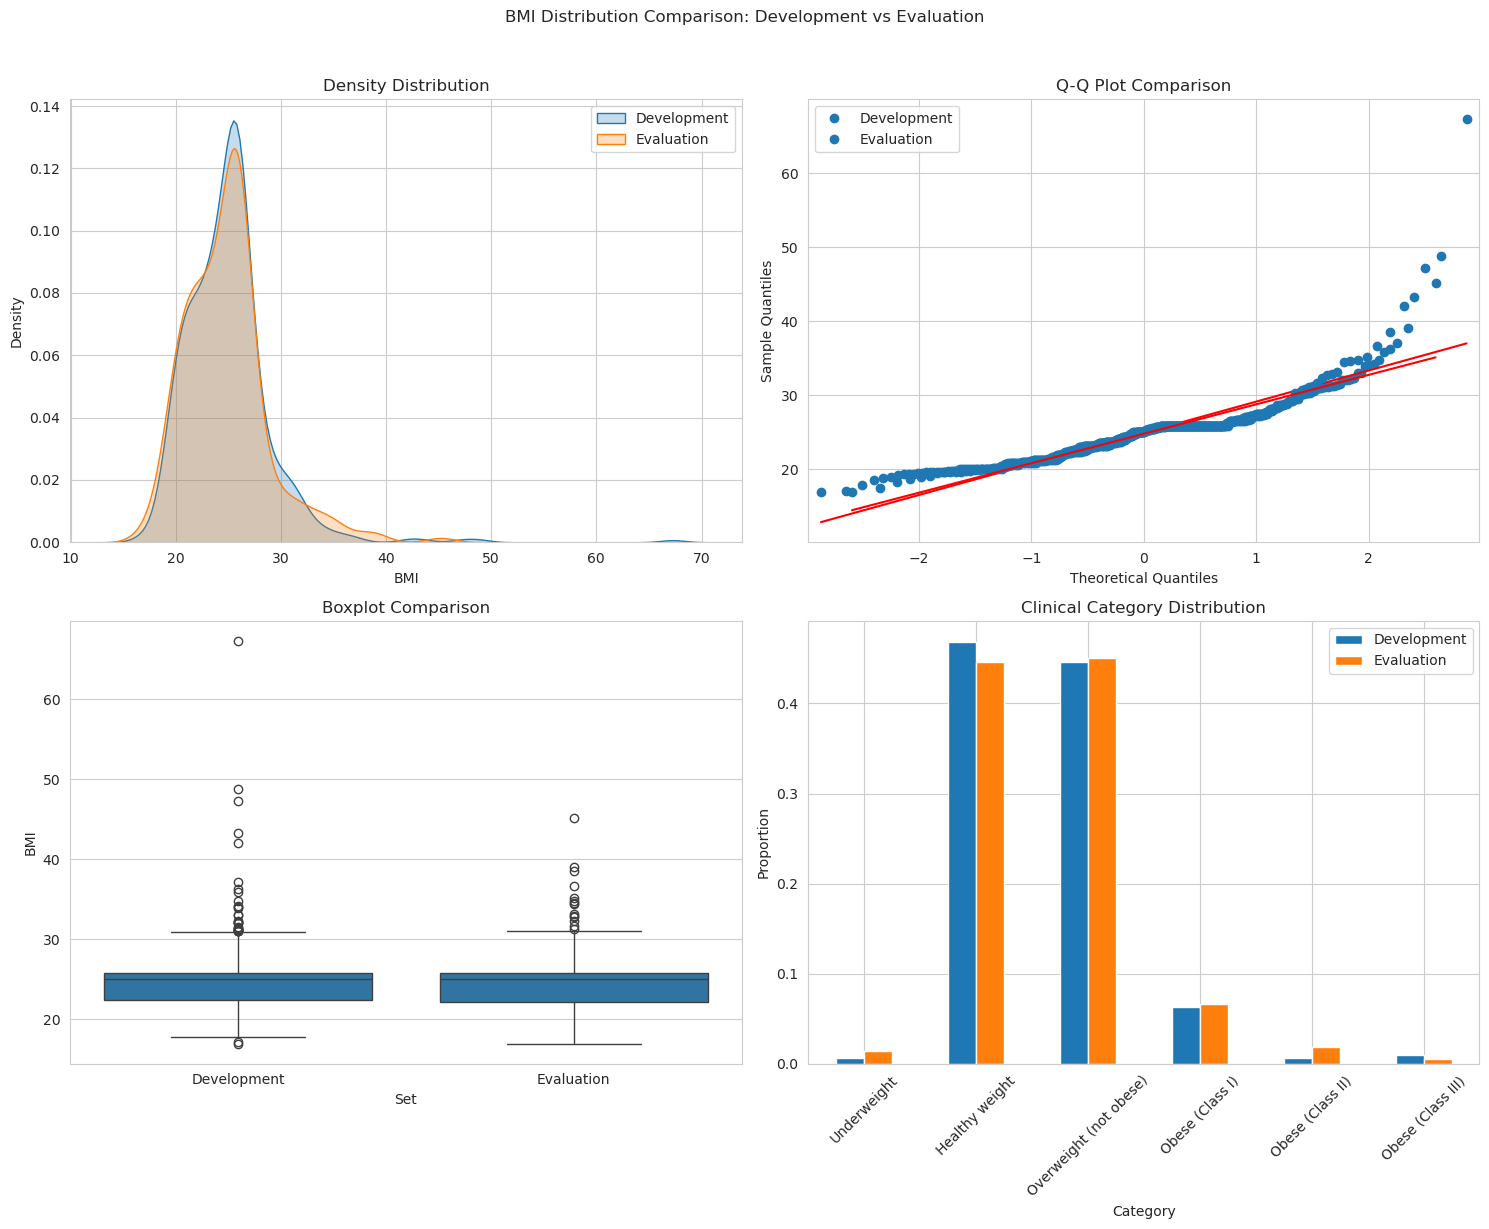

,Development,Evaluation
count,489.00000,211.000000
mean,24.93955,24.800853
std,4.20771,3.987255
min,16.97000,16.970000
25%,22.38000,22.220000
50%,25.10000,25.100000
75%,25.80000,25.800000
max,67.26000,45.200000


In [77]:
results = analyze_distributions(data_dev, data_val, col_check='BMI', label1='Development', label2='Evaluation')
pd.DataFrame(results['Descriptive Statistics'])

### Next we check the distribution of values and features that are equal to zero in our datasets

In [79]:
zero_stats_dev = describe_zero_inflation(data_dev)
zero_stats_eval = describe_zero_inflation(data_val)

Zero-Inflation Analysis Report
Total values: 66,504
Total zeros: 35,462 (53.3%)
Zero-inflated features (> 50% zeros): 72/136 (52.9%)

Top 5 most zero-inflated features:
                                         zero_proportion
Ruminococcaceae bacterium D16                      97.3%
Flavonifractor plautii                             96.9%
Clostridium asparagiforme                          96.7%
Lachnospiraceae bacterium 3_1_57FAA_CT1            96.3%
Lachnospiraceae bacterium 7_1_58FAA                93.3%

Zero-Inflation Analysis Report
Total values: 28,696
Total zeros: 15,536 (54.1%)
Zero-inflated features (> 50% zeros): 76/136 (55.9%)

Top 5 most zero-inflated features:
                                         zero_proportion
Ruminococcaceae bacterium D16                     100.0%
Flavonifractor plautii                             99.5%
Clostridium asparagiforme                          99.1%
Lachnospiraceae bacterium 3_1_57FAA_CT1            98.6%
Lachnospiraceae bacterium 7_1_58FA

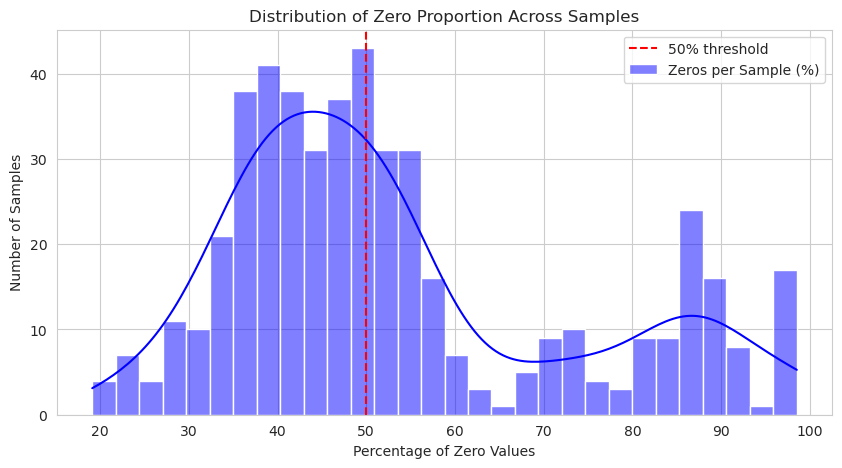

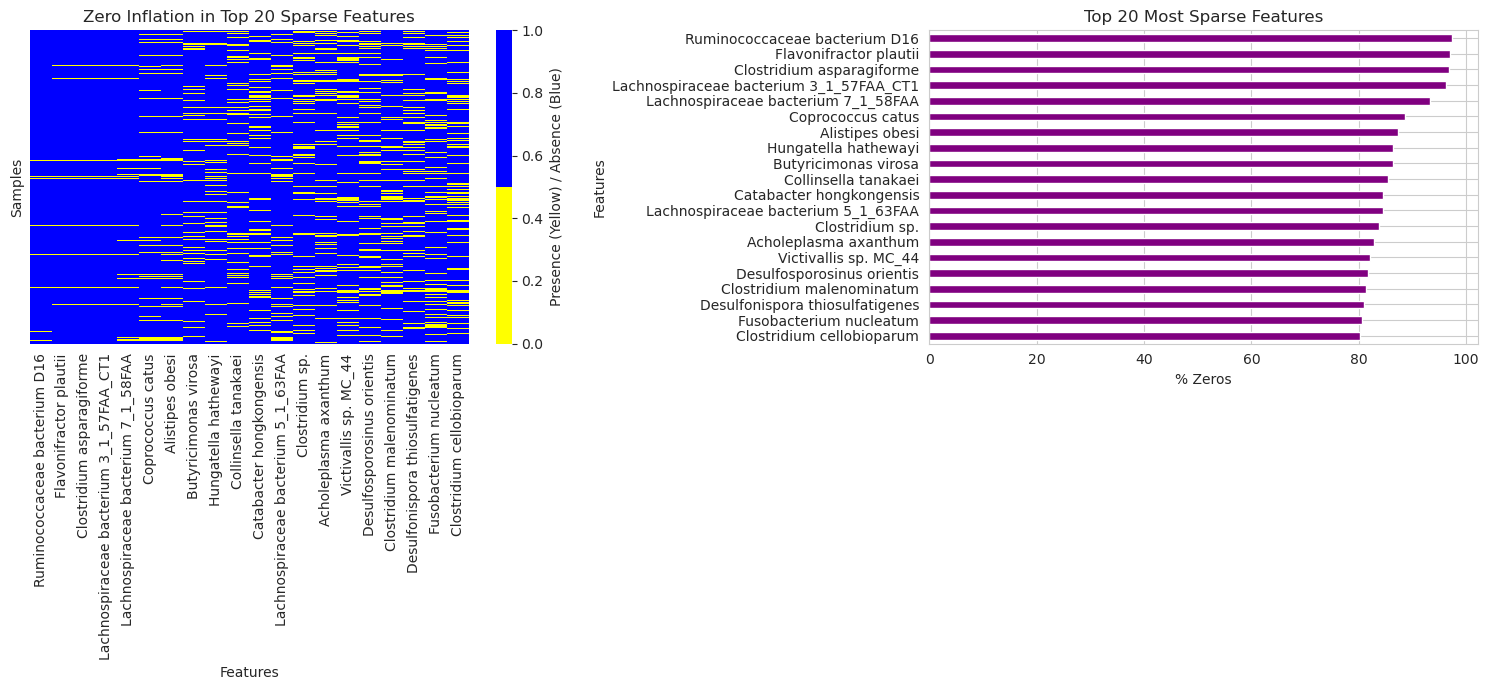

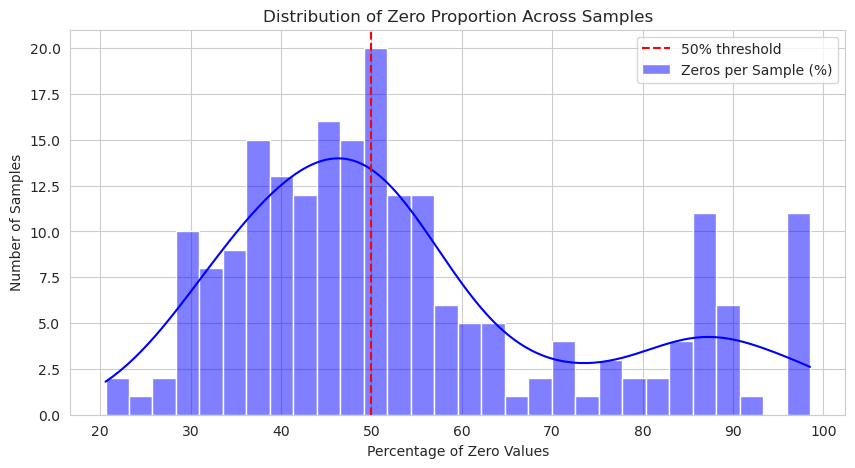

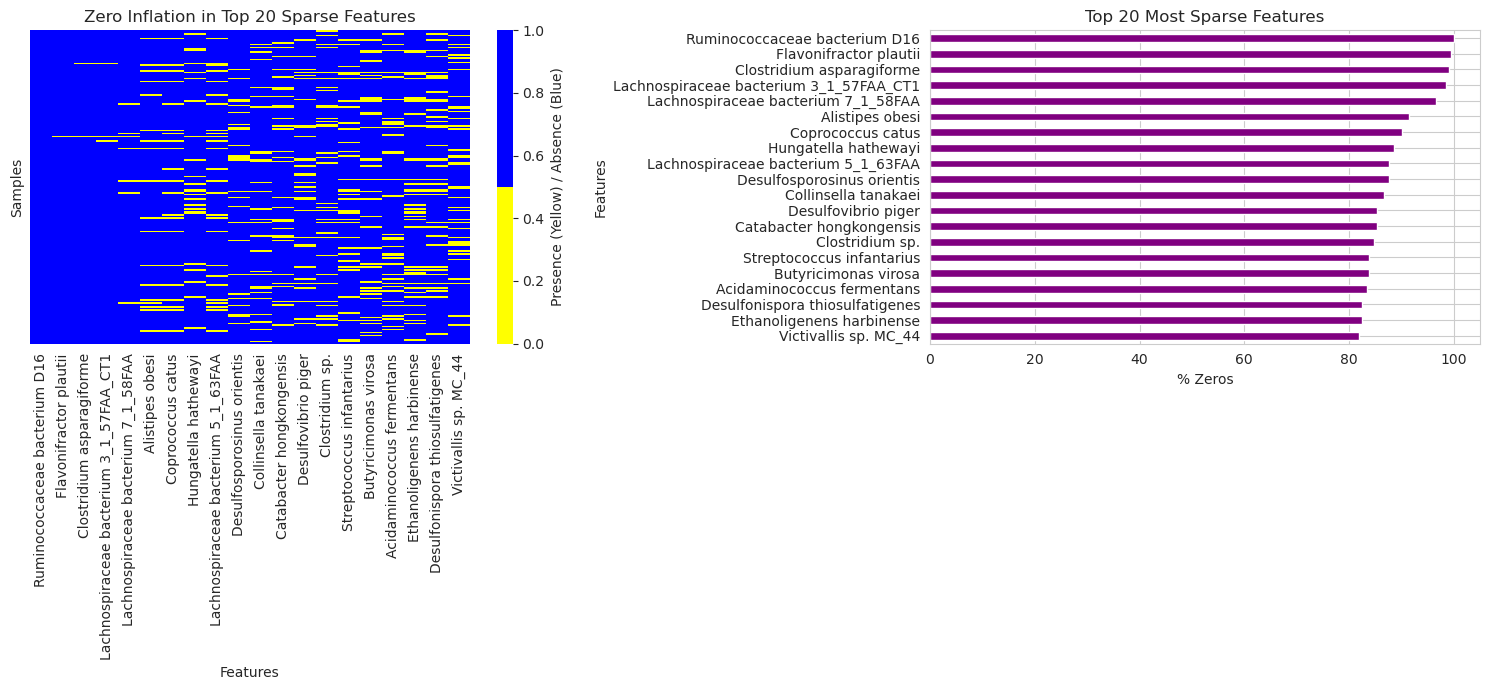

In [78]:
visualize_zero_inflation(data_dev)
visualize_zero_inflation(data_val)

### Need for transformation

**We can see that the datasets are severely zero inflated so they need preprocessing. The choosen preprocessing removes samples that have zero values for all microbial features, adds psesudocounts to eliminate all zeros and finally transforms the data using centered log-ratio transformation**

### To get a sense of the transformed microbiome data we find and plot the most correlated features and plot their distributions

In [82]:
processed_dev, processed_eval = preprocess_and_save_datasets(data_dev, data_val)

Processing development set...
Processing evaluation set...
Processed datasets saved to:
Development set: ../data/development_final_data.csv
Evaluation set: ../data/evaluation_final_data.csv

Processing Summary:
Development set: 489 → 472 samples
Evaluation set: 211 → 200 samples


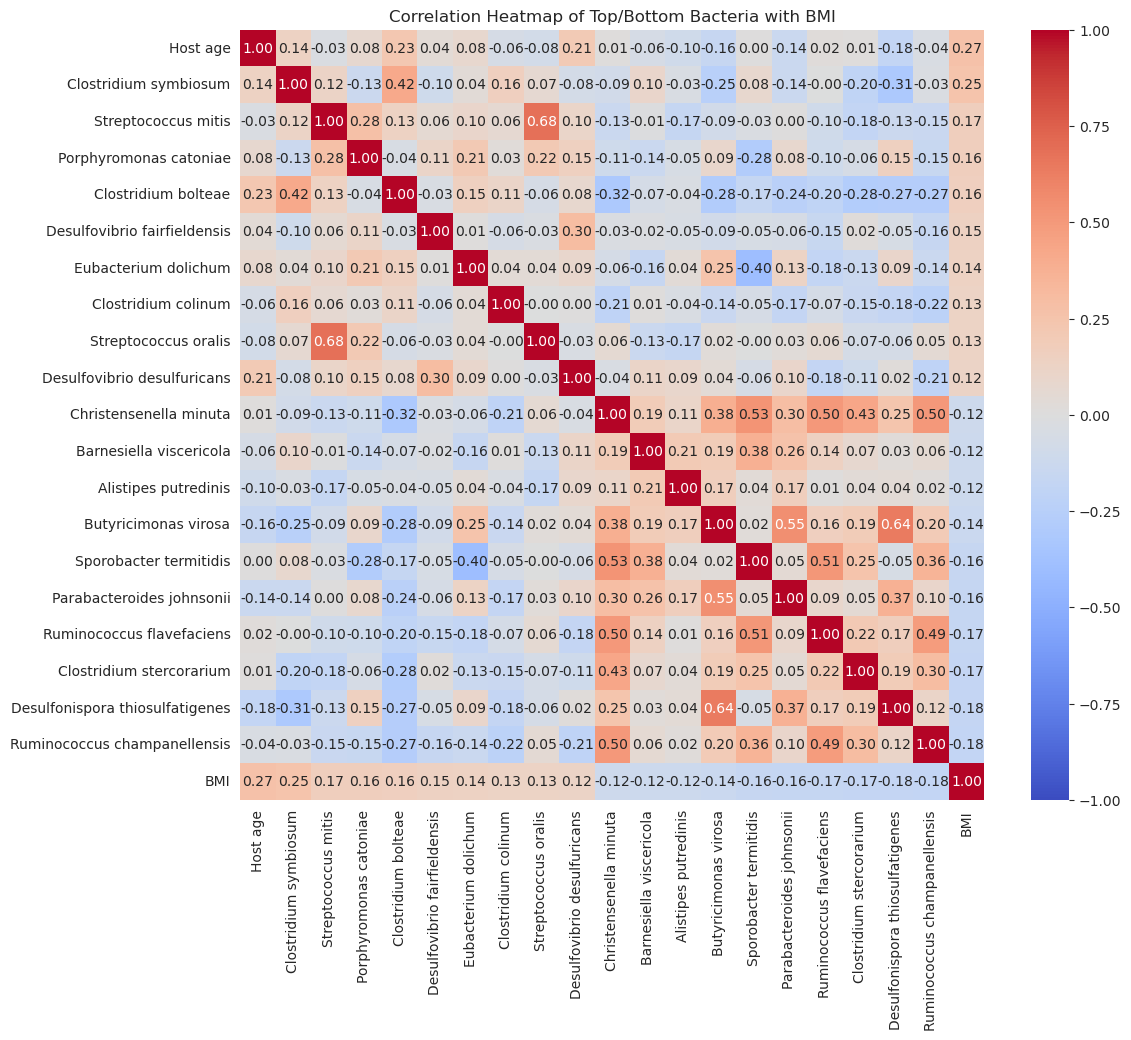

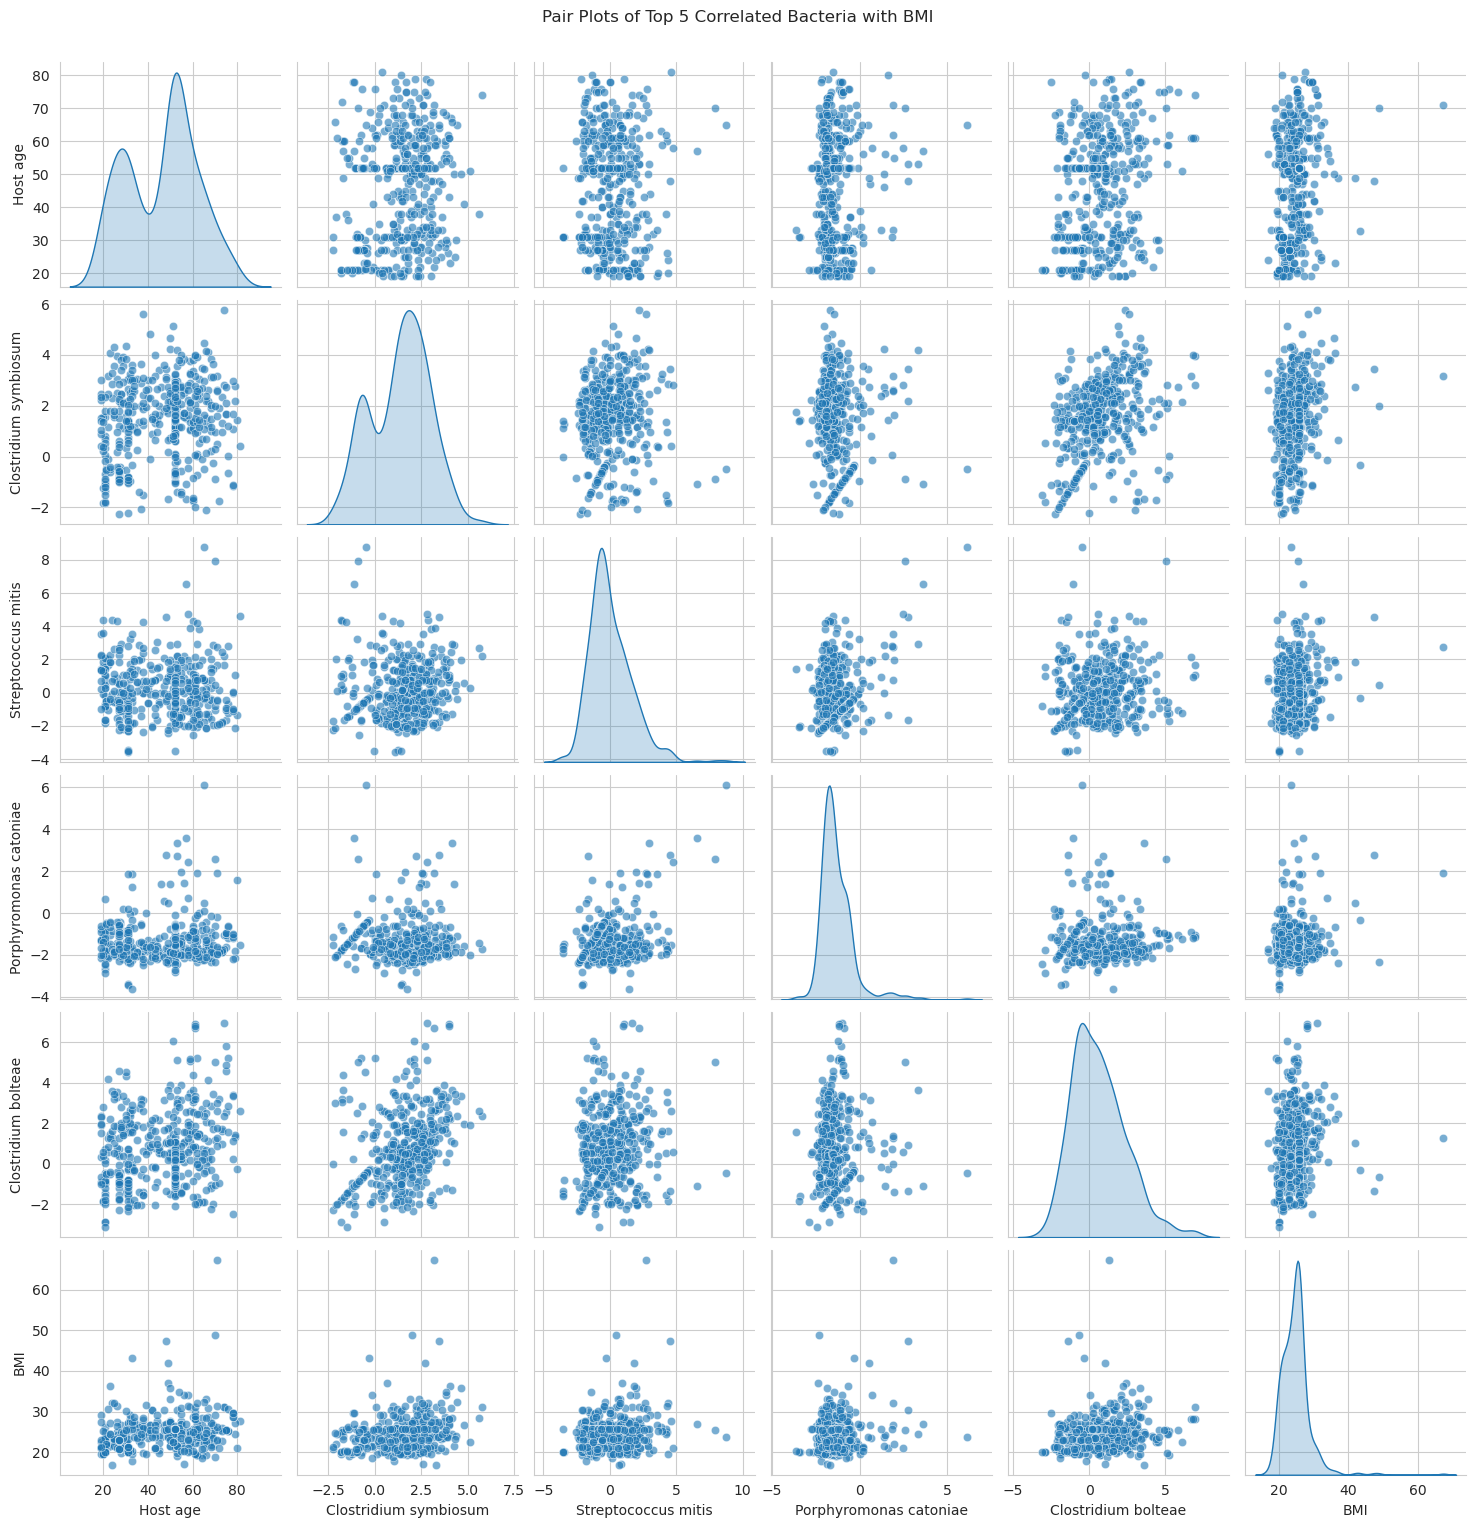

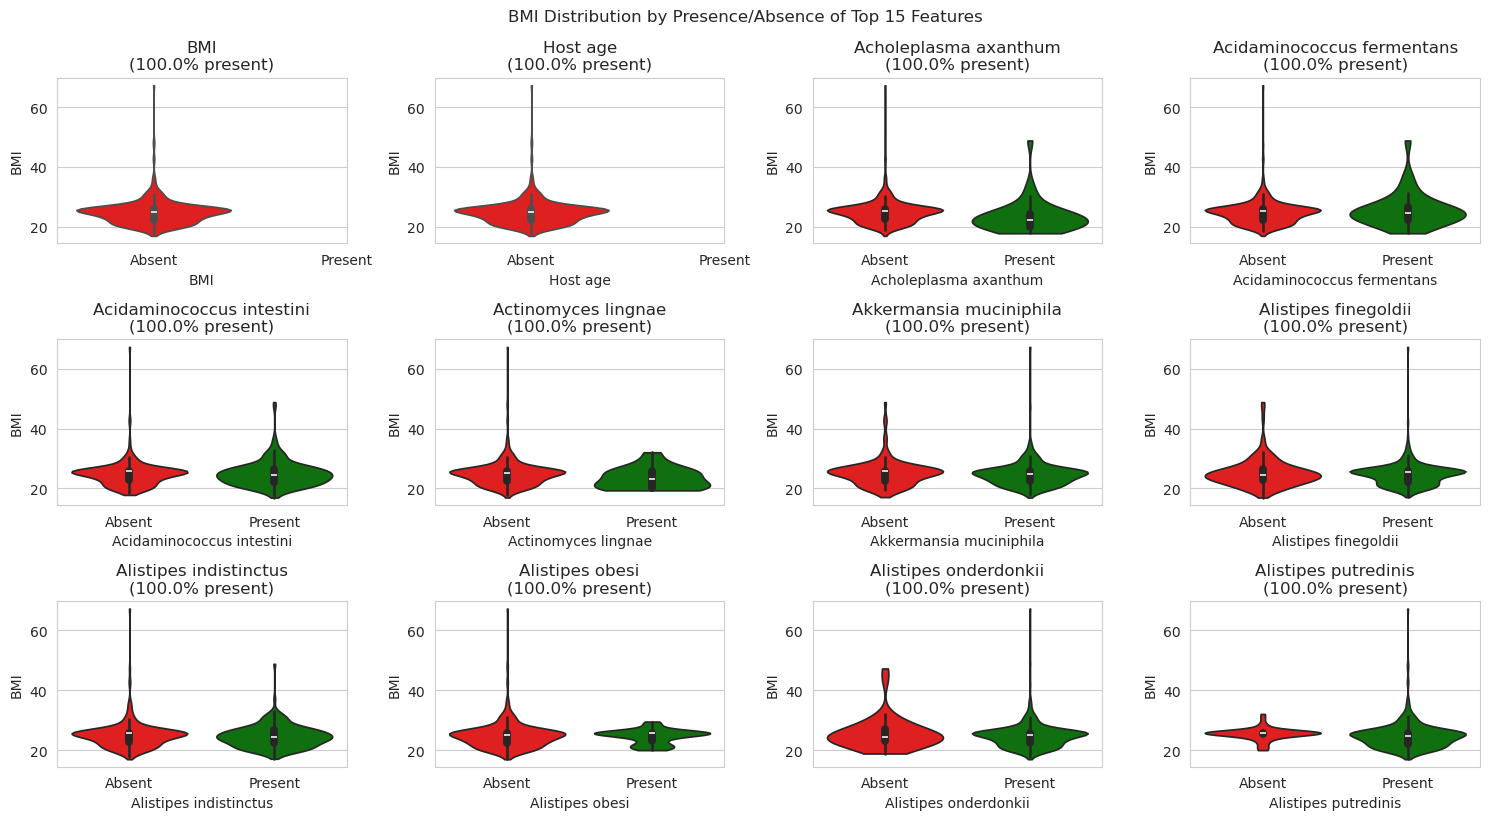

,feature,prevalence,spearman_r,spearman_p,pointbiserial_r,pointbiserial_p
0,BMI,1.0,1.000000,0.000000e+00,NaN,NaN
1,Host age,1.0,0.282788,3.960727e-10,NaN,NaN
2,Acholeplasma axanthum,1.0,-0.092344,5.867216e-01,-0.093453,0.042420
3,Acidaminococcus fermentans,1.0,0.137826,4.369728e-01,0.056169,0.223215
4,Acidaminococcus intestini,1.0,0.100787,1.587756e-01,0.015575,0.735733
...,...,...,...,...,...,...
130,Clostridium xylanolyticum,1.0,-0.078945,3.061538e-01,0.089548,0.051869
131,Eubacterium brachy,1.0,-0.278604,6.258919e-03,-0.091156,0.047785
132,Eubacterium dolichum,1.0,0.284757,2.744039e-02,0.085049,0.064866
133,Eubacterium sulci,1.0,-0.130304,7.088772e-02,-0.016461,0.721310


In [84]:
feature_results_dev = analyze_microbial_features(processed_dev, top_n=15)
pd.DataFrame(feature_results_dev['correlation_analysis'])

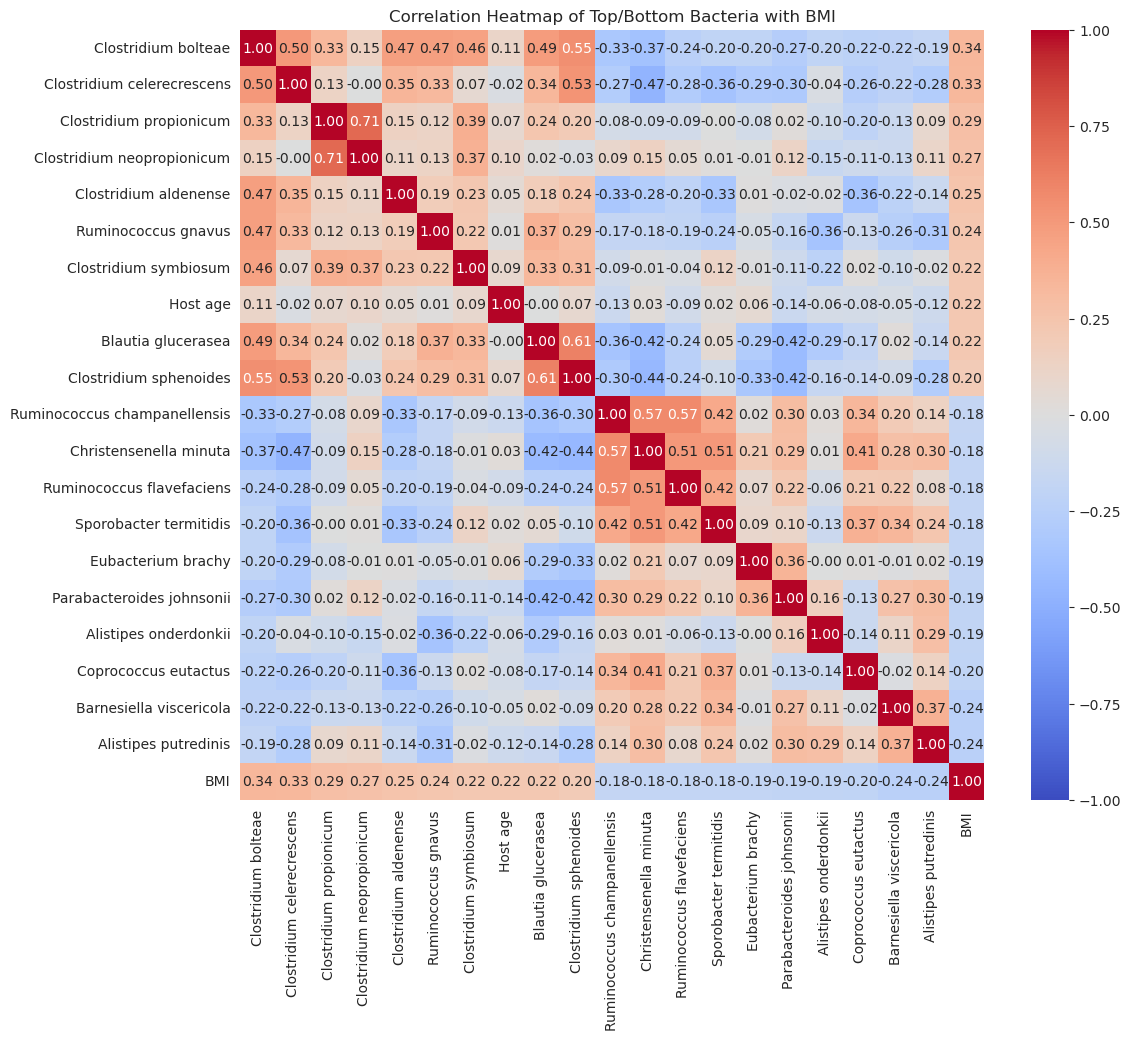

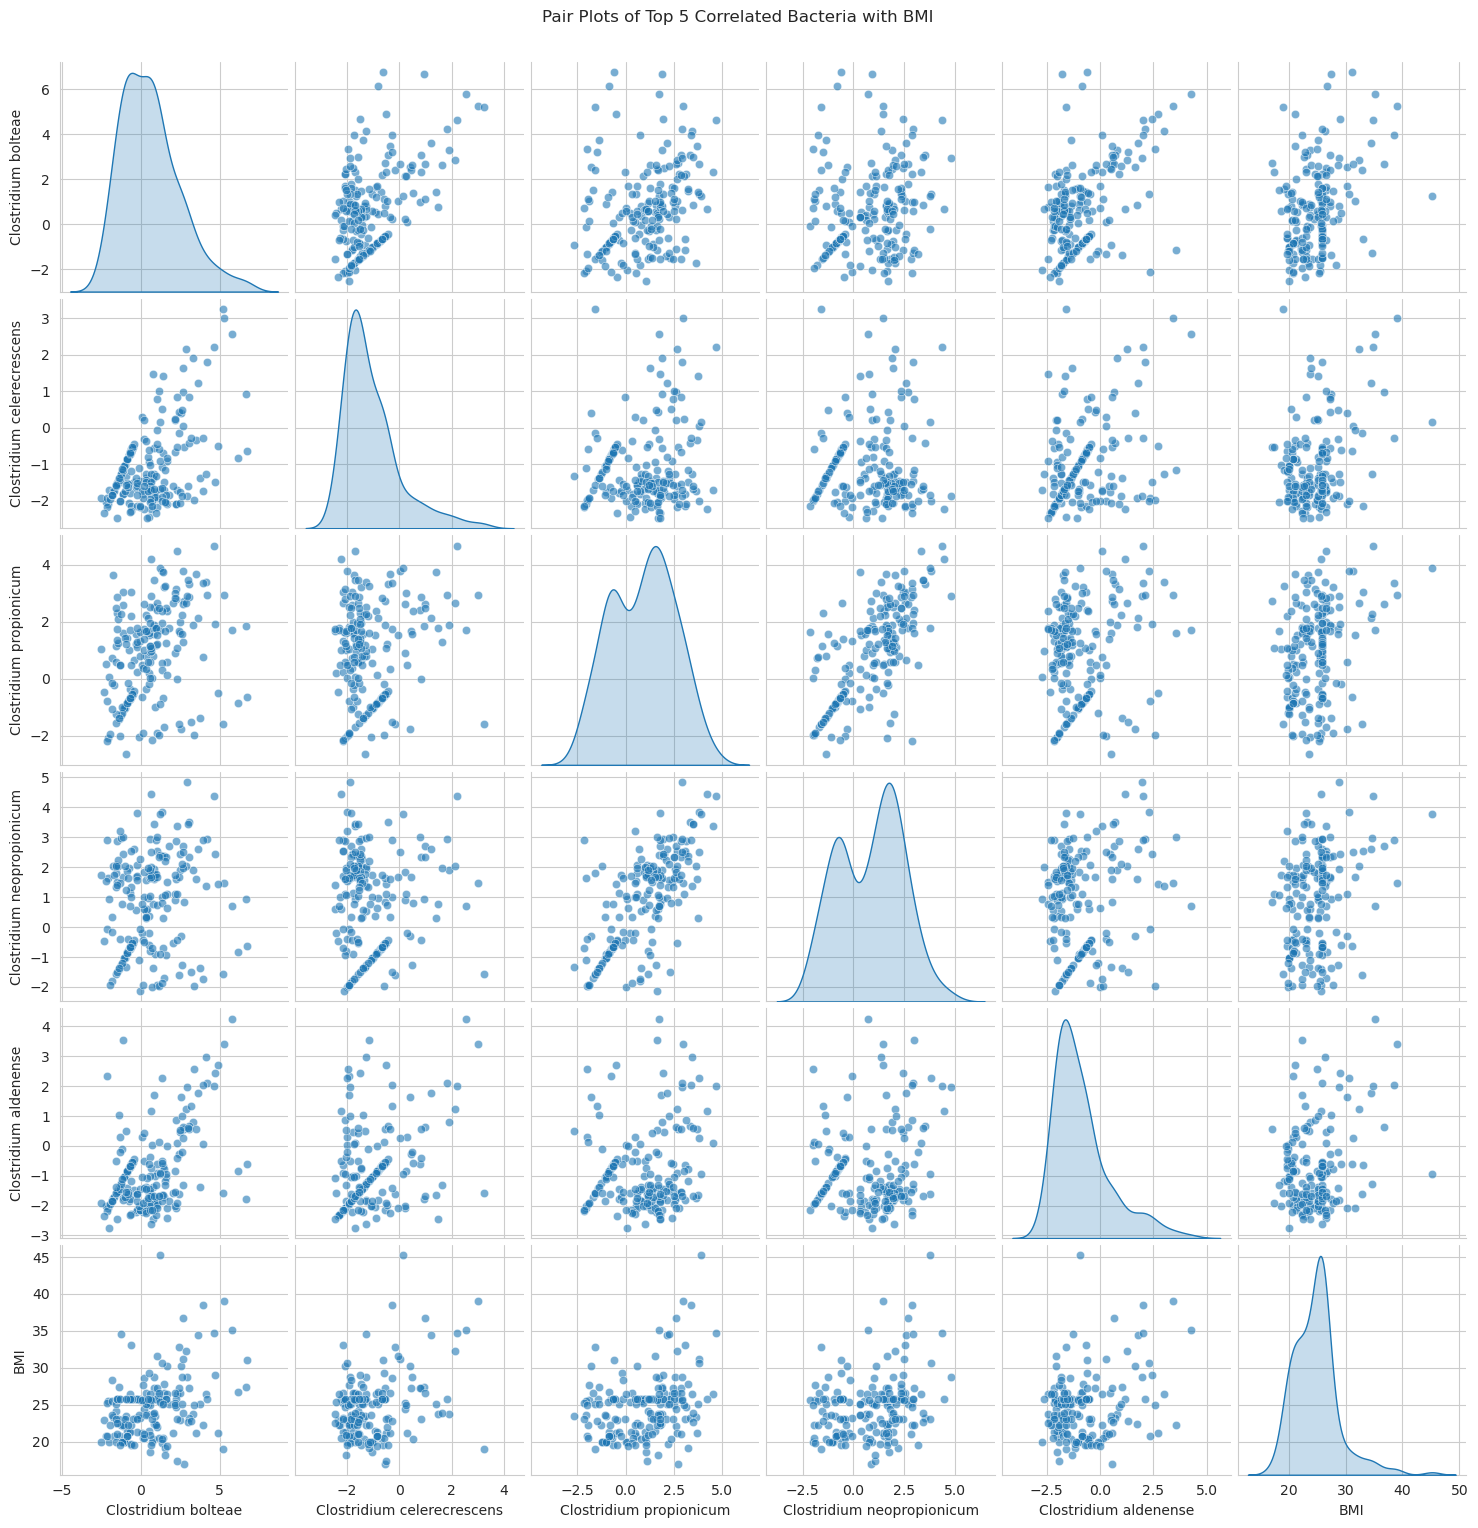

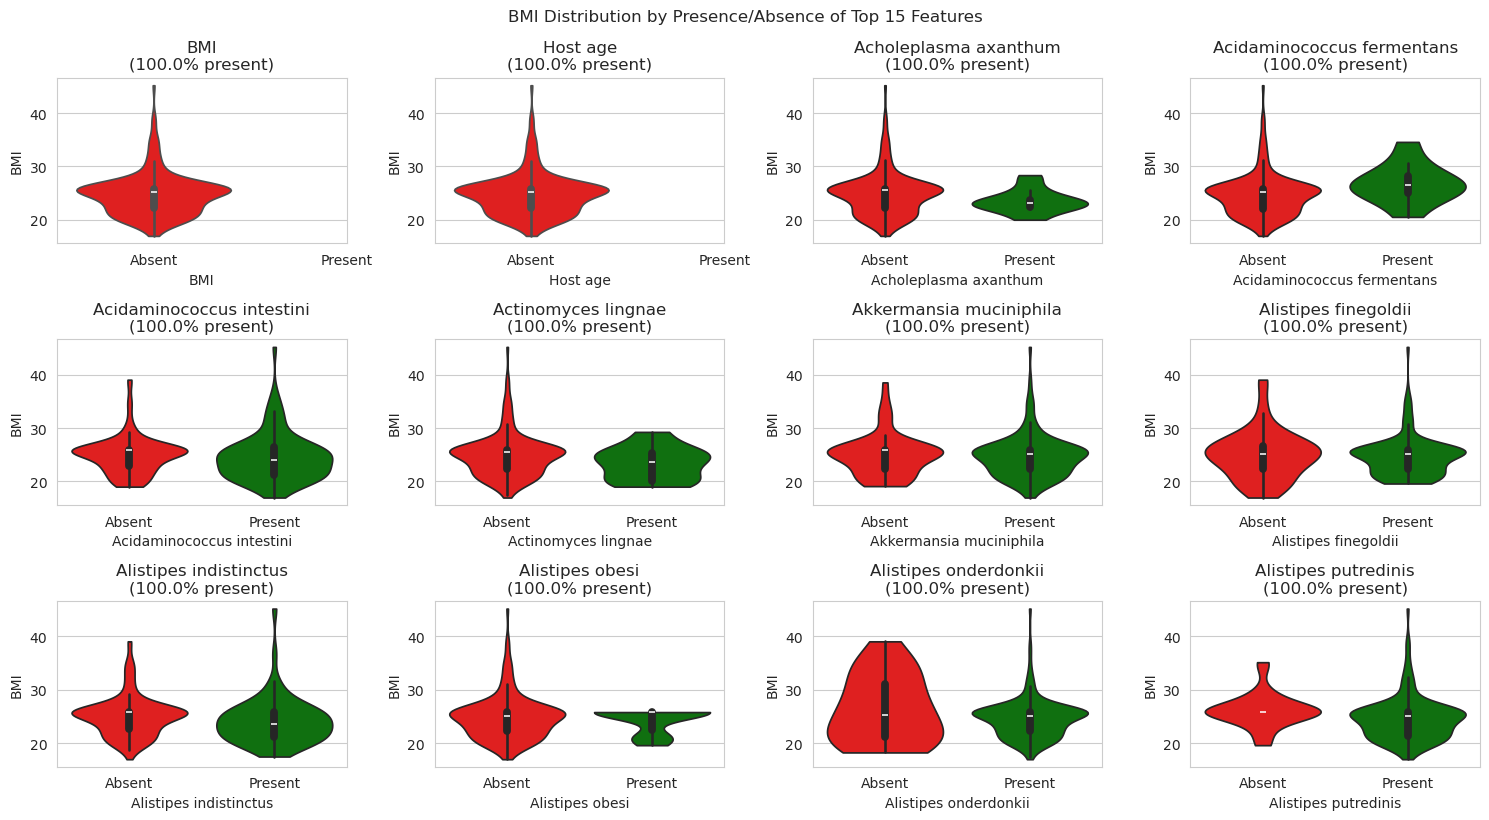

,feature,prevalence,spearman_r,spearman_p,pointbiserial_r,pointbiserial_p
0,BMI,1.0,1.000000,0.000000,NaN,NaN
1,Host age,1.0,0.237996,0.000690,NaN,NaN
2,Acholeplasma axanthum,1.0,-0.198651,0.444666,-0.095734,0.177500
3,Acidaminococcus fermentans,1.0,0.678817,0.021637,0.123744,0.080855
4,Acidaminococcus intestini,1.0,0.188246,0.077289,-0.048835,0.492268
...,...,...,...,...,...,...
120,Clostridium xylanolyticum,1.0,0.068975,0.535521,0.105820,0.135874
121,Eubacterium brachy,1.0,-0.343247,0.020977,-0.094537,0.183005
122,Eubacterium dolichum,1.0,-0.073893,0.714147,0.086011,0.225896
123,Eubacterium sulci,1.0,0.109327,0.343897,-0.008585,0.903962


In [85]:
feature_results_eval = analyze_microbial_features(processed_eval, top_n=15)
pd.DataFrame(feature_results_eval['correlation_analysis'])